# Fig_4 : SDSS-PS1 stellar offsets and QSO contours 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
import celerite
import modules as mod
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [3]:
# Read in a summary table, made in
# ../code/AC_summary_photo_offsets.ipynb 
summary = Table.read('../code/summary_combined_lc_info.txt', format='ascii')

First, plot just Fig.4 for Quasars, showing the underlying data and the KDE contous with 30%,70%,90% levels 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



Picking KDE pdf pixels that would include     the following percentages of the input data:
[0.3, 0.7, 0.9]

Picking KDE pdf pixels that would include     the following percentages of the input data:
[0.3, 0.7, 0.9]

Picking KDE pdf pixels that would include     the following percentages of the input data:
[0.3, 0.7, 0.9]


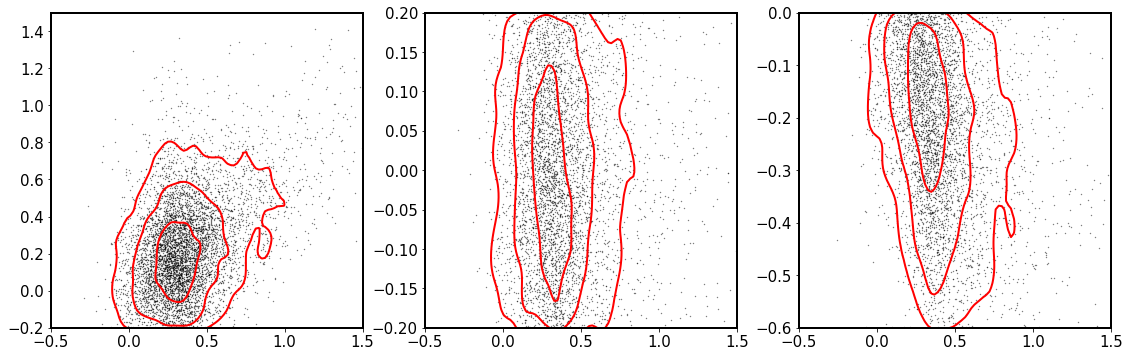

In [37]:
%matplotlib inline

sdss_gi = summary['SDSS_mediangmag'] - summary['SDSS_medianimag']

targetbands = 'r'
if targetbands is 'r' : 
        ymax = {'g':1.5,'r':0.2, 'i':   0,'z':0,   'y':0}
        ymin = {'g':-0.2,'r':-0.2,'i':-0.6,'z':-0.8,'y':-0.8}
        
originbands = 'gri'
nrows, ncols = 1,3
fig,ax = plt.subplots(nrows,ncols, figsize=(6*ncols+1,5.8*nrows))

i = 0 
levels = [0.3,0.7,0.9]
xlims = [-0.5,1.5]

for f1 in originbands : 
    #ax[i].hexbin(sdss_gi, diff , extent=[-0.5,1.5,ymin[f1],ymax[f1]]) 
    # (left, right, bottom, top). 
    x = sdss_gi
    y = summary['PS1_median'+f1+'mag'] - summary['SDSS_medianrmag']
    
    mx = (xlims[0] < x ) * (x < xlims[1])
    my = (ymin[f1] < y) * (y < ymax[f1])
    
    m = mx * my 
    
    x = x[m]
    y  = y[m]
    
    ax[i].scatter(x,y,s=2, lw=0, c='k', alpha=0.5 )
    
    xx, yy, z = mod._statsmodels_bivariate_kde(x,y,'scott',100,3,None)
    
    outline = ax[i].contour(xx, yy, z , 
                        levels = mod.cumsum_contour_levels(z, levels), 
                        colors='r', linestyles='-' ,linewidths=2)
    ax[i].set_xlim(xlims)
    ax[i].set_ylim(ymin[f1], ymax[f1])
    i += 1 

Add these to the readily written function that plots the stellar locus ... 

In [42]:
# Try to combine all in one function ...
%matplotlib inline 
def photometric_offset_sdss_ps1(data, summary, sdsscolors = 'gr', 
                                targetbands = 'grizz', originbands = 'grizy',
                                s82mag = 'mmed', s82err = 'msig',
                                cutoffmag = 19 , xlims = [-0.5,2.5],
                                correct_extinction = True, 
                                ebv_sfd = None,
                                extinction = 'SFD', nrows=2, ncols=3,
                                storeStarID = False,qsoContourLevels = [0.3,0.7,0.9]
                               ):
    '''
    Find photometric offsets between SDSS and PS1, 
    or another survey. 
    
    data :  a table containing ugriz SDSS stellar photometry, cross-matched to 
            the target survey, eg. SDSS-PS1
    summary : a table containing SDSS-PS1-CRTS average light curve photometry
        (medians) for quasars
    qsoContourLevels : an array of percentage of data to be included in 
        consecutive KDE levels drawn 
    sdsscolors : SDSS colors used to spread the stellar locus.  It can be 
           "gr" or "gi" (this mainly affects the x-axis limits)
           
    targetbands : SDSS bands to emulate. It can be "r" if all photometry 
           from target survey should be compared to SDSS(r), eg. 
           PS1(gri) --> SDSS(rrr),  or "grizz"  if each source band
           should be compared to an equivalent SDSS band, eg.
           PS1(grizy) --> SDSS(grizz)  (as in Tonry2012 for PS1).
           
    originbands : bands present in the origin survey. Eg, for PS1 they're 
           'grizy'
    
    cutoffmag : magnitude cutoff to ignore very faint stars according
          to SDSS target magnitude (eg. if yaxis is "grizz" then we filter
          by "grizz < cutoffmag" separately for each panel)
          
    xlims : limits on the x-axis in magnitudes (depends on the 
          SDSS color chosen for the x-axis). By default, [-0.5,2.5]
          
    correct_extinction : shall we correct for  interstellar extinction before 
          finding offsets ? If "True" , then "ebv_sfd"  needs to be provided,
          which is expected to be an array of the same length as the input SDSS 
          table ("data"). E(B-V) is selective extinction at V, or "reddening" : 
          E(B-V) = (B-V)_obs - (B-V)_true , with B,V being magnitudes in B,V. 
          Then the "total extinction" A(V) in a given filter, eg. V, is linked to 
          E(B-V) via the "extinction law"  : 
          A(V) = R(V) * E(B-V) , where R(V) is most commonly taken to be 3.1 . 
          The total extinction is expressed in magnitudes, that have to be
          subtracted from the observed magnitudes - object becomes brighter : 
          m_(V,corr) = m_(V,obs) - A(V), 
          so that the corrected distance modulus : 
          5 * log_10(d_(V,corr)) = m_(V,obs) - A(V) - M_V + 5 = 
                                 = m_(V,corr) - M_V + 5
        If correct_extinction = False , then we do not correct for extinction. 
                                 
    ebv_sfd : the table of interstellar reddening in units of Schlegel,Finkbeiner,Davis,
          which can be translated to total extinction A(b) in each band b using the 
          coefficients from Table6 in Schlegel,Finkbeiner2011, assuming RV = 3.1 .
          
    extinction : which reddening data from dustmaps  was used?  Eg. 
          "SFD"   Schlegel,Finkbeiner,Davis1998
          "Bayestar17"  
          
        # Example of obtaining SFD and Bayestar EBV_SFD using dustmaps
        # 1 : query 2D  SFD1998 map 
        import dustmaps.sfd
        dustmaps.sfd.fetch()
        from dustmaps.sfd import SFDQuery
        sfd = SFDQuery()
        coords  = SkyCoord(sdss_ps1['ra_sdss']*units.deg,
                           sdss_ps1['dec_sdss']*units.deg,
                           frame='icrs')
        ebv_1 = sfd(coords)

        # 2 query 3D Bayestar17 map 
        import dustmaps.bayestar
        dustmaps.bayestar.fetch()
        from dustmaps.bayestar import BayestarQuery
        coords  = SkyCoord(sdss_ps1['ra_sdss']*units.deg,
                           sdss_ps1['dec_sdss']*units.deg, 
                           distance=4*units.kpc,
                           frame='icrs')
        bayestar = BayestarQuery(max_samples=1)
        ebv_2 = bayestar(coords, mode='median')
        
        Both ebv_1  and ebv_2  would be appropriate examples of reddening 
        in SFD units. 
         
    nrows, ncols : number of rows and columns for the plot. 
        Recommended :  if originbands  = 'grizy'  (PS1) , then (nrows,ncols)=(3,2),
        if 'gri' (PS1)  --> (2,2) , 
        if 'gR' (PTF)  --> (1,2)
        if  'V' (CRTS) --> (1,1) 
    '''
    # $ Table 6 SF2011 Coefficients with RV=3.1 from EBV_SFD to A
    ebv_sfd_to_A = {'p1g':3.172, 'p1r':2.271, 'p1i':1.682, 'p1z':1.322, 'p1y':1.087,
        'sdssu':4.239, 'sdssg':3.303, 'sdssr':2.285, 'sdssi':1.698, 'sdssz': 1.263}

    # set file names ,  figure title .. 
    
    if correct_extinction : 
        #suptitle='Extinction corrected  : dustmaps ' +  extinction
        ext = 'ext-'+extinction
    else:
        #suptitle  = 'No extinction correction'
        ext = 'ext-NO'

    # extinction coefficients for SDSS Standards 
    #Cm = {'u':1.873, 'g':1.377, 'r':1.0, 'i':0.758, 'z':0.537}
    #Ar = sdss_ps1['AR_val']

    # we subtract the extinction coefficient, 
    # 'brightening' the given star
    #gmag = sdss_ps1['g_mMed'] -  Cm['g'] * Ar
    #rmag = sdss_ps1['r_mMed'] -  Cm['r'] * Ar
    #imag = sdss_ps1['i_mMed'] -  Cm['i'] * Ar  
    
    # correct SDSS photometry for extinction ... 
    if correct_extinction : 
        gmag = data['g'+s82mag] - ebv_sfd_to_A['sdssg'] * ebv_sfd
        rmag = data['r'+s82mag] - ebv_sfd_to_A['sdssr'] * ebv_sfd
        imag = data['i'+s82mag] - ebv_sfd_to_A['sdssi'] * ebv_sfd
    else:
        gmag = data['g'+s82mag] 
        rmag = data['r'+s82mag]
        imag = data['i'+s82mag] 


    # Coefficients from Schlegel,Finkbeiner2011
    #ps1_coeffs = {'g':3.172,  'r':2.271 , 'i':1.682, 
    #             'z':1.322 , 'y':1.087} 
    
    #xaxis : 'gi' or 'gr'
    if sdsscolors is 'gr': 
        x =  gmag-rmag   # SDSS (g-r)
        xQSOlims = [-0.25, 0.75]
        xFITlims = [0.1, 1.1]
    if sdsscolors is 'gi' : 
        x = gmag-imag  # SDSS (g-i)
        xQSOlims = [ -0.2, 0.8 ]
        xFITlims = [0.25, 1.5]
        

    #yaxis : 'SDSSgrizz' or 'SDSSr'
    if targetbands is 'grizz' : 
        ymin = {'g':-0.3,'r':-0.3,'i':-0.3,'z':-0.3,'y':-0.3}
        ymax = {'g':0.2,'r':0.2, 'i':0.2, 'z':0.2,   'y':0.2}
        SDSSfilters = 'grizz'
        
    if targetbands is 'r' : 
        ymax = {'g':1.5,'r':0.2, 'i':   0,'z':0,   'y':0}
        ymin = {'g':-0.2,'r':-0.2,'i':-0.6,'z':-0.8,'y':-0.8}
        SDSSfilters = len(originbands) * 'r'

    # define the plotting space 
    fig,axs = plt.subplots(nrows,ncols, figsize=(6*ncols+1,5.8*nrows))
    ax = np.ravel(axs)
    i = 0 
    
    # make a table to store coefficients derived from this set of data 
    coeffs  = {'x' : [], 'y' : [], 'B_0' : [], 'B_1':[]}
    
    sdss_gi = summary['SDSS_mediangmag'] - summary['SDSS_medianimag']
    
        
    for f1,f2 in zip(originbands, SDSSfilters):  
        print(' ')
        # store filters used 
        coeffs['x'].append('('+sdsscolors[0]+'-'+sdsscolors[1]+')_SDSS')
        coeffs['y'].append(f1 + '_P1-'+f2+'_SDSS)')
        
        print('Starting with ', len(data[f1+'MeanPSFMag']), 'stars in filter PS1 ', f1)
        
        # remove stars that have no PS1 obs in that filter 
        ma = data[f1+'MeanPSFMag'] > 0
        print('- Removing ', np.sum(~ma) , 
              ' objects that do not have PS1 obs in that filter')
        
        # remove faint stars to clean up the plot  : I'm sure that's 
        # what Tonry did, although not mentioned explicitly ... 
        mb = data[f2 + s82mag] < cutoffmag
        print('- Removing ', np.sum(~mb), 
              ' objects that are have SDSS ',f2, ' mag fainter  than ', cutoffmag)
        
        # apply the two criteria from the header 
        # to stripe82calibStars_v2.6.dat : 
        ###  1) To select sources with reliable photometry in the u and z bands
        ###     don't forget to require Nobs >= 4
        ###  2) to avoid a slight bias (~0.02 mag) at the faint end in the gri  
        ###     bands, require msig*sqrt(Nobs) < 0.03 
        # ---> point 2 not needed, because we are NOT USING FAINT END !!! 
        #mc = data['u_mErr'] * np.sqrt(data['u_Nobs']) < 0.03
        #print('- Removing ', np.sum(~mc), ' objects that do not fulfill ',
        #     ' mErr * sqrt(Nobs) < 0.03 criterion ')
        m1 = ma * mb #* mc 
        
        if f2 is 'u' or f2 is 'z' : 
            md = data[f2+'_Nobs']  >= 4
            print('- Removing ',np.sum(~md), 
                  ' objects that have less than 4 obs in  this band')
            m1 = ma * mb * mc * md 

        print('= Left with ', np.sum(m1), ' objects')
        
        if storeStarID : 
            # store the starID of stars used for the offset .... 
            name = 'StarID_PS1'+f1+'-SDSS'+f2+'_'+ext+'.txt'
            data[['starID', 'RA', 'Dec']][m1].write(name, format='ascii', 
                                                    overwrite=True)
            print('Stored the starIDs of all stars used for this offset as ', name )

        if correct_extinction :
        
            # Correct for extinction using 
            # Ab based on ebv_sfd from 
            # dustmaps sfdquery
            # and example on their website 
            # https://dustmaps.readthedocs.io/en/latest/examples.html
            #Av = ps1_coeffs[f1] * ebv_sfd
            #ps1mag  = sdss_ps1[f1+'MeanPSFMag'] - Av

            ps1mag = data[f1+'MeanPSFMag'] - ebv_sfd_to_A['p1'+f1]*ebv_sfd

            # correct SDSS using data from the Table of standards
            #sdssmag  = sdss_ps1[f2+'_mMed'] - Cm[f2] * Ar 
            sdssmag  = data[f2 +s82mag] - ebv_sfd_to_A['sdss'+f2]*ebv_sfd
            
        else: # use uncorrected values 
            ps1mag = data[f1+'MeanPSFMag']
            sdssmag  = data[f2 + s82mag]
            
        y  = ps1mag - sdssmag  # fPS1 - fSDSS

        # combine errors in quadrature to use as weights in 
        # fitting with polynomial 
        e1 = data[f1+'MeanPSFMagErr'] # PS1 error on the Mean 
        e2 = data[f2+s82err]  # SDSS standard error for the mean
        

        # remove stars that have no obs in that filter 
        ax[i].hexbin(x[m1],y[m1], extent= (xlims[0],xlims[1], 
                                           ymin[f1],ymax[f1]), bins='log'
                     )
        ########################
        # plot QUASAR contours #
        ########################
    
        xq = sdss_gi
        yq = summary['PS1_median'+f1+'mag'] - summary['SDSS_medianrmag']

        mx = (xlims[0] < xq ) * (xq < xlims[1])
        my = (ymin[f1] < yq) * (yq < ymax[f1])

        mq = mx * my 

        xq  = xq[mq]
        yq  = yq[mq]
        
        # plot the underlying data points
        #ax[i].scatter(xq,yq,s=2, lw=0, c='w', alpha=0.5 )
        
        # plot the KDE contours 
        xx, yy, z = mod._statsmodels_bivariate_kde(xq,yq,'scott',100,3,None)
        outline = ax[i].contour(xx, yy, z , 
                        levels = mod.cumsum_contour_levels(z, qsoContourLevels), 
                        colors='r', linestyles='-' ,linewidths=2)        
        
        ax[i].set_xlim(xlims)
        ax[i].set_ylim(ymin[f1], ymax[f1])
        
        # add text about the filter combination being plotted 
        ax[i].text(x = 0.1, y=0.1, s = f1+r'$_{\mathrm{P1}}$'+'-'+f2+r'$_{\mathrm{SDSS}}$', 
               color='yellow', fontsize=20, transform=ax[i].transAxes)

        # mark with vertical lines  the range occupied by QSO
        # the y limits are in axis coords 
        ax[i].axvline(xQSOlims[0], ymin=0.25, ymax=0.85 , ls='--', lw=3, c='orange')
        ax[i].axvline(xQSOlims[1], ymin=0.25, ymax=0.85, ls='--', lw=3, c='orange')

        # make my own linear fits 
        m2 = (xFITlims[0]<x)*(x<xFITlims[1]) # within the vertical dashed lines 
        m3 = (ymin[f1] < y) *(y < ymax[f1]) # within the ylims of the plot 
        m_ = m1*m2*m3
    
        if f1 is 'y' :  # remove points below this line ...
            x1,y1 = 0.0, -0.2
            x2,y2 = 1.0, -0.6
            a = (y2-y1)/ (x2-x1)
            b = y1-a*x1
            m4 = y > (a * x + b )
            m_ = m1*m2*m3 * m4

        # fit first degree polynomial
        xf  = x[m_] ;  yf=y[m_] ; ef = np.sqrt(e1[m_]**2.0 + e2[m_]**2.0)
        
        #ax[i].scatter(xf,yf , s=0.01)
        p = np.polyfit(xf,yf,deg=1, w=1/ef)
        # y = B_0 + B_1 * x  in Tonry+2012 
        coeffs['B_1'].append(p[0]) 
        coeffs['B_0'].append(p[1])  
        
        x_ = np.linspace(xFITlims[0],xFITlims[1], 100)
        ax[i].plot(x_, p[0] *x_ + p[1]  , c='red')

        # Plot Tonry's fits 
        if (sdsscolors is 'gr') and (targetbands is 'grizz') : 
            # plot Tonry's linear fits 
            # i-th row because we also iterate over  grizy_P1 
            xt = np.linspace(xlims[0],xlims[1],100)
            print(tonry[i]['y'])
            yt = tonry[i]['B_0'] + tonry[i]['B_1'] * xt
            ax[i].plot(xt,yt, c='pink')

            # plot Tonry's quadratic fits 
            # i-th row because we also iterate over  grizy_P1 
            #yt = tonry[i]['A_0'] + tonry[i]['A_1'] * xt + tonry[i]['A_1'] * xt * xt
            #ax[i].plot(xt,yt, c='magenta')
        i += 1 

    #print(coeffs)
    
    #  remove the last subplot if 2x2...
    
    #ax[i].set_visible(False) 
    # for 2x2,  0.5,  0.05 
    fig.text(0.45,0.01, '('+sdsscolors[0]+'-'+sdsscolors[1]+') SDSS [mag]', fontsize=21)
    # for 2x2,  0.01, 0.5 
    fig.text(0.07,0.7, 'PS1-SDSS [mag] ', fontsize=21, rotation=90)
    
    fig.subplots_adjust(wspace=0.25)
    
    #fig.suptitle(suptitle, fontsize=18)
    #figtitle = 'Offsets_PS1-SDSS'+targetbands+'_SDSS'+sdsscolors+'_'+ext+'.png'
    figtitle = 'Fig04_offsets_SDSS-PS1.pdf'
    print('Figure saved as ', figtitle)
    plt.savefig(figtitle,
               bbox_inches='tight', dpi=100)
    
    c  = Table(coeffs)
    tabtitle = 'Offsets_PS1-SDSS'+targetbands+'_SDSS'+sdsscolors+'_'+ext+'.txt'
    c.write(tabtitle, format='ascii', overwrite='True')
    print('Coefficients stored as an ascii table ', tabtitle)
    

In [ ]:
sdss_ps1  = Table.read('../code/sdss_ps1_stripe82calibStars.txt', format='ascii')


 
Starting with  48250 stars in filter PS1  g
- Removing  3446  objects that do not have PS1 obs in that filter
- Removing  27082  objects that are have SDSS  r  mag fainter  than  19
= Left with  19716  objects


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



Picking KDE pdf pixels that would include     the following percentages of the input data:
[0.3, 0.7, 0.9]
 
Starting with  48250 stars in filter PS1  r
- Removing  2112  objects that do not have PS1 obs in that filter
- Removing  27082  objects that are have SDSS  r  mag fainter  than  19
= Left with  19863  objects

Picking KDE pdf pixels that would include     the following percentages of the input data:
[0.3, 0.7, 0.9]
 
Starting with  48250 stars in filter PS1  i
- Removing  1634  objects that do not have PS1 obs in that filter
- Removing  27082  objects that are have SDSS  r  mag fainter  than  19
= Left with  20064  objects

Picking KDE pdf pixels that would include     the following percentages of the input data:
[0.3, 0.7, 0.9]
Figure saved as  Fig04_offsets_SDSS-PS1.pdf
Coefficients stored as an ascii table  Offsets_PS1-SDSSr_SDSSgi_ext-NO.txt


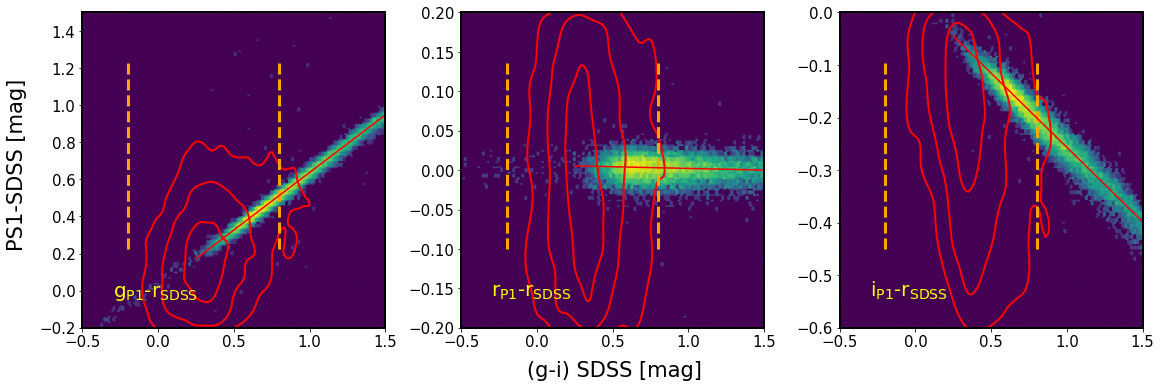

In [43]:

# Use as needed :  Fourth combination:  
# SDSS (g-i) vs PS1(grizy)  - SDSS(rrrrr ) : 
photometric_offset_sdss_ps1(data = sdss_ps1, summary=summary, sdsscolors = 'gi', targetbands = 'r',
                            originbands = 'gri',s82mag = '_mMed', s82err = '_mErr',
                            cutoffmag = 19 , xlims = [-0.5,1.5] ,
                            correct_extinction = False ,ebv_sfd = None,
                            extinction = None, nrows = 1, ncols =3, )